In [1]:
from pyquil.api import BenchmarkConnection
from pyquil import get_qc, Program
from pyquil.gates import CZ, I, H, S, MEASURE, X, CNOT, FENCE, RZ
from pyquil.paulis import PauliTerm, ID
from pyquil.latex import display
from pyquil.quil import Pragma

In [2]:
import networkx as nx
from math import pi
from itertools import cycle, product, permutations
from random import choice
from scipy.optimize import curve_fit, nnls
import scipy as sc
import numpy as np
from itertools import combinations
from matplotlib import pyplot as plt
from collections import Counter

In [3]:
DOUBLE_GATE = 2
SINGLE_GATE = 1
NUM_BASES = 9

class LearningProcedure:
    def __init__(self, layer, qpu):
        self.qubits = layer.get_qubits()
        self.layer = Program([inst for inst in layer if len(inst.get_qubits()) == 2])
        self.n = len(self.qubits)
        topology = qpu.qubit_topology().subgraph(self.qubits)
        self.qpu = qpu

        self.bases = self.pauli_bases(topology)
        self.model_paulis = self.model_terms(topology)

    def pauli_bases(self, connectivity : nx.Graph):
        n = self.n
        remaining = self.qubits.copy() 

        bases = [ID()]*NUM_BASES
        while remaining:
            vertex = remaining.pop()
            #copied from Fig. S3 in van den Berg
            orderings = {"XXXYYYZZZ":"XYZXYZXYZ",
                                "XXXYYZZZY":"XYZXYZXYZ",
                                "XXYYYZZZX":"XYZXYZXYZ",
                                "XXZYYZXYZ":"XYZXZYZYX",
                                "XYZXYZXYZ":"XYZZXYYZX"}

            children = connectivity.neighbors(vertex) 
            predecessors = [c for c in children if c not in remaining]

            match len(predecessors):
                #trivial if no predecessors
                case 0:
                    cycp = cycle("XYZ")
                    for i,_ in enumerate(bases):
                        bases[i] *= PauliTerm(next(cycp),vertex)
                #Choose p1:"XXXYYYZZZ" and p2:"XYZXYZXYZ" if one predecessor
                case 1:
                    pred, = predecessors
                    #store permutation of indices so that predecessor has X,X,X,Y,Y,Y,Z,Z,Z
                    bases = list(list(zip(*sorted(zip([p[pred] for p in bases], bases))))[1])
                    cycp = cycle("XYZ")
                    for i,_ in enumerate(bases):
                        bases[i] *= PauliTerm(next(cycp),vertex)
                case 2:
                    pred0,pred1 = predecessors
                    bases = list(list(zip(*sorted(zip([p[pred0] for p in bases], bases))))[1])
                    #list out string with permuted values of predecessor 2
                    substr = [p[pred0] for p in bases]
                    #match predecessor two with a permutation of example_orderings
                    reordering = ""
                    for perm in permutations("XYZ"):
                        p_substr = "".join(["XYZ"[perm.index(p)] for p in p_substr])
                        if p_substr in orderings:
                            current = orderings[p_substr] 
                            for i,p in enumerate(current):
                                bases[i] *= PauliTerm(p,vertex)
                            break
                case _: #processor needs to have connectivity so that there are <= 2 predecessors
                    raise Exception("Three or more predecessors encountered")

        print([s.pauli_string(self.qubits) for s in bases])

        return bases

    def model_terms(self, topology):
        model_terms = []

        #get all single-weight paulis
        for i in topology.nodes:
            for op in "XYZ":
                model_terms.append(PauliTerm(op, i))
                
        #get all weight-two paulis on with suport on nieghboring qubits
        for (q1,q2) in topology.edges:
            for op1,op2 in product("XYZ", repeat=2):
                model_terms.append(PauliTerm(op1, q1)*PauliTerm(op2,q2))

        print("The terms included in the model are the following:", [p.pauli_string(self.qubits) for p in model_terms])
        return model_terms

    def instance(
        self, 
        prep_basis, 
        meas_basis, 
        noise_repetitions : int, 
        transpiled=True
        ):

        n = self.n
        qubits = self.qubits
        bc = BenchmarkConnection()

        circ = Program(Pragma('INITIAL_REWIRING', ['"NAIVE"']))
        ro = circ.declare("ro", "BIT", self.n)

        #get preparation ops from desired basis 
        def prep(basis, qubit):
            if basis == "X":
                return H(qubit)
            elif basis == "Y":
                return Program(H(qubit),S(qubit))
            return I(qubit)

        def meas(basis, qubit):
            if basis == "X":
                return H(qubit)
            elif basis == "Y":
                return Program(RZ(-pi/2, qubit), H(qubit))
            return I(qubit)
        
        pauli_frame = ID()

        #apply the prep and twirling operators to the circuit
        qc = Program()
        qc += [prep(b,qubit) for qubit,b in prep_basis]

        #apply repetitions of noise, including basis-change gates when needed
        for i in range(noise_repetitions):
            twirl = PauliTerm.from_list([(choice("IXYZ"),q) for q in self.qubits]) 
            qc += twirl.program

            if transpiled:
                qc = self.qpu.compiler.quil_to_native_quil(qc)
                qc.pop()
                circ += qc
            else:
                circ += qc

            circ += self.layer
            qc = Program()
            pauli_frame *= twirl
            pauli_frame = bc.apply_clifford_to_pauli(self.layer, pauli_frame)
        rostring = PauliTerm.from_list([(choice("IX"),q) for q in self.qubits]) 
        qc += pauli_frame.program
        qc += [meas(b,q) for q,b in meas_basis]
        qc += rostring.program

        if transpiled:
            qc = self.qpu.compiler.quil_to_native_quil(qc)
            qc.pop()
            circ += qc
        else:
            circ += qc
        
        circ += [MEASURE(q,ro[i]) for i,q in enumerate(self.qubits)]

        return circ, {
            "prep_basis":prep_basis,
                "meas_basis":meas_basis, 
                "depth":noise_repetitions, 
                "rostring": tuple({"I":0,"X":1}[char] for char in  rostring.pauli_string(self.qubits))
            }

    def procedure(
        self,
        depths,
        samples,
        shots,
        single_samples = None,
        transpiled = True
    ):

        if isinstance(samples, int):
            samples = [samples]*len(depths)
        if not single_samples:
            single_samples = samples[0]

        self.depths = depths
        self.single_samples = single_samples
        bc = BenchmarkConnection()
    
        pairs = [(p,bc.apply_clifford_to_pauli(self.layer, p)) for p in self.model_paulis]

        single_measurements = [(p1,p2) for (p1,p2) in pairs if p1 != p2 and len(p1) == 1 and len(p2) == 2]
        single_measurements += list(set([frozenset([p1,p2]) for p1,p2 in pairs if p1 != p2 and len(p1) == len(p2) == 2]))
        single_measurements = [list(s) for s in single_measurements]

        print("The following pairs require single measurements:", single_measurements)

        circuits = []
        metadatas = []
        bases = self.bases
        total = len(bases)*sum(samples)+len(single_measurements)*single_samples

        j=0
        for basis, (d,s) in product(bases, zip(depths,samples)):

            for i in range(s):
                circ, data = self.instance(
                    basis, 
                    basis, 
                    d,
                    transpiled
                    )

                j+=1
                print(j,"/",total, end='\r')
                circ.wrap_in_numshots_loop(shots)
                circuits.append(circ)
                metadatas.append(dict(**data, type = "double"))
        
        for (pauli, pair), s in product(single_measurements, range(single_samples)):

            circ, data = self.instance(
                pair,
                pauli,
                1,
                transpiled
            )
            j+=1
            print(j,"/",total, end='\r')
            circ.wrap_in_numshots_loop(shots)
            circuits.append(circ)
            metadatas.append({"type":"single", **data})

        print("Generated", len(circuits), "circuits")

        return circuits, metadatas

In [9]:
qpu = get_qc("Aspen-1-16Q-A",as_qvm = True,noisy=True)
layer = Program(CZ(0,1))
tglp = LearningProcedure(layer, qpu)

ValueError: pyQuil currently does not support initializing a noisy QuantumComputer based on a QCSQuantumProcessor. Change noisy to False or specify the name of a QVM.

In [16]:
circ, data = tglp.instance(PauliTerm.from_list([("X",0),("Y",1)]),PauliTerm.from_list([("X",0),("Y",1)]),2, transpiled=True)

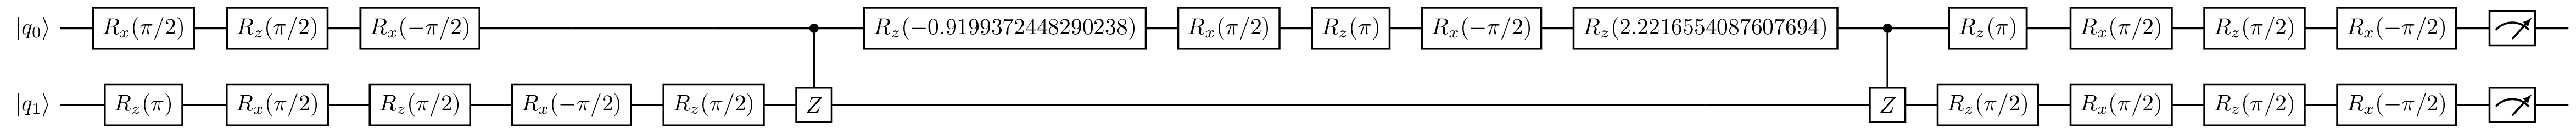

In [17]:
display(circ)

In [19]:
circuits, metadatas = tglp.procedure([2,4,16], 50, 50, transpiled=False)

The following pairs require single measurements: [[(1+0j)*X0, (1+0j)*X0*Z1], [(1+0j)*Y0, (1+0j)*Y0*Z1], [(1+0j)*X1, (1+0j)*Z0*X1], [(1+0j)*Y1, (1+0j)*Z0*Y1], [(1+0j)*X0*Y1, (-1+0j)*Y0*X1], [(-1+0j)*X0*Y1, (1+0j)*Y0*X1], [(1+0j)*Y0*Y1, (1+0j)*X0*X1]]
Generated 1700 circuits


In [537]:
results = []
from collections import Counter
for i,circ in enumerate(circuits):
    print(i, end='\r')
    exe = qpu.compiler.native_quil_to_executable(circ)
    res = qpu.run(exe).readout_data['ro']
    l = [tuple(r) for r in res]
    results.append(Counter(l))

In [25]:
class ProcedureAnalysis:
    def __init__(self, layer, depths, single_samples, model_terms):
        self.qubits = layer.get_qubits()
        self.layer = Program([inst for inst in layer if len(inst.get_qubits()) == 2])
        self.n = len(layer.get_qubits())
        self.single_samples = single_samples
        self.depths = depths
        self.model_terms = model_terms

    @classmethod
    def fromExperiment(cls, experiment):
        return cls(
            experiment.layer,
            experiment.depths,
            experiment.single_samples,
            experiment.model_paulis
        )

    def get_expectation(self, measurement, **metadata):
        total = 0
        counts = metadata['counts']
        pauli_weight = [{"I":0}.get(p,1) for p in measurement.pauli_string(self.qubits)]
        rostring = metadata['rostring']
        for key in counts.keys():
            ro_adjusted = np.bitwise_xor(key, rostring)
            sgn = np.dot(pauli_weight, ro_adjusted)
            total += (-1)**sgn*counts[key]
        return total/sum(counts.values())

    def analyze(self, results, metadatas):

        bc = BenchmarkConnection()

        def simultaneous_measurements(pauli):
            sim_meas = []
            for i,p in enumerate(pauli):
                for subset in combinations(pauli, i+1):
                    sim_meas.append(PauliTerm.from_list([tuple(reversed(s)) for s in subset]))
            return sim_meas

        depths = self.depths
        single_samples = self.single_samples
        #Sort into single and double measurements
        results_dict = [{**metadata, "counts":count} for metadata,count in zip(metadatas,results)]
        singles = []
        doubles = []
        for datum in results_dict:
            type = datum["type"]
            datum.pop("type")
            if type == "single":
                singles.append(datum)
            elif type == "double":
                doubles.append(datum)

        expfit = lambda x,a,b: a*np.exp(-b*x)

        #reorder by measurement basis
        basis_dict = {}
        for datum in doubles:
            basis = datum['prep_basis']
            depth = datum['depth']
            for pauli in simultaneous_measurements(basis):
                expectation = self.get_expectation(pauli, **datum)
                if not pauli in basis_dict:
                    basis_dict[pauli] = {"expectation":[0 for d in depths], "total":[0 for d in depths]}
                basis_dict[pauli]["expectation"][depths.index(depth)] += expectation
                basis_dict[pauli]["total"][depths.index(depth)] += 1

        self_conjugates = []
        pair_measurements = []
        for key in basis_dict.keys():
            for i,d in enumerate(depths):
                basis_dict[key]["expectation"][i] /= basis_dict[key]["total"][i]
            try:
                popt, pcov = curve_fit(expfit, depths, basis_dict[key]["expectation"], p0=[.9,.01])
                basis_dict[key]["fidelity"] = expfit(1,1,popt[1])
                basis_dict[key]["SPAM"] = popt[0]
            except:
                print("warning: fit did not converge for", key, "using 1")
                basis_dict[key]["fidelity"] = 1
                basis_dict[key]["SPAM"] = 1

            if key != bc.apply_clifford_to_pauli(self.layer, key):
                pair_measurements.append(((key.pauli_string(self.qubits),bc.apply_clifford_to_pauli(self.layer,key).pauli_string(self.qubits)), basis_dict[key]["fidelity"]))
                basis_dict[key]["type"] = "pair"
            else:
                self_conjugates.append((key.pauli_string(self.qubits), basis_dict[key]["fidelity"]))
                basis_dict[key]["type"] = "single"

        print("The following SPAM-free measurements were reconstructed:", self_conjugates)
        print("The following SPAM-free measurement pairs were constructed:", pair_measurements)

        singles_dict = {}

        for datum in singles:
            counts = datum['counts']
            prep_basis = datum['prep_basis']
            meas_basis = datum['meas_basis']

            if meas_basis not in singles_dict:
                singles_dict[meas_basis] = 0

            expectation = self.get_expectation(meas_basis, **datum)
            avg = basis_dict[meas_basis]['SPAM']
            fidelity = np.min([1.0,np.abs(expectation)/avg])
                
            singles_dict[meas_basis] += fidelity/single_samples

        for key in singles_dict.keys():
            basis_dict[key]['fidelity'] = singles_dict[key]
            basis_dict[key]['type'] = "single"

        print("The following degeneracy-lifting measurements were reconstructed:", list(zip([p.pauli_string(self.qubits) for p in singles_dict.keys()], singles_dict.values()))) 

        self.data = basis_dict 
        return self.data

    def fit_model(self):
        F1 = []
        F2 = []
        fidelities = []
        for key in self.model_terms:
            F1.append(key)
            fidelities.append(self.data[key]['fidelity'])
            if self.data[key]["type"] == "pair":
                pair = bc.apply_clifford_to_pauli(self.layer, key)
                F2.append(pair)
            else:
                F2.append(key)
        
        sprod = lambda a,b: int(a.anticommutes(b))
        M1 = [[sprod(a,b) for a in self.model_terms] for b in F1]
        M2 = [[sprod(a,b) for a in self.model_terms] for b in F2]

        if np.linalg.matrix_rank(np.add(M1, M2)) != len(self.model_terms):
            raise Exception("Matrix is not full rank, something went wrong")

        coeffs,rnorm = sc.optimize.nnls(np.add(M1,M2), -np.log(fidelities))
        print("Model reconstructed with r-norm", rnorm)
        return list(zip(coeffs, self.model_terms))

    def graph(self, *paulis):
        expfit = lambda x,a,b: a*np.exp(-b*x)
        colcy = cycle("rgbcmk")
        for p in paulis:
            c = next(colcy)
            data = self.data[p]['expectation']
            popt, pcov = curve_fit(expfit, self.depths, data, p0=[.9,.01])
            xrange = np.linspace(0,np.max(self.depths))
            plt.plot(self.depths, data, c+"X")
            plt.plot(xrange, [expfit(x, *popt) for x in xrange], c)

        plt.show()

    def display(self, *paulis):
        bc = BenchmarkConnection()
        ax = np.arange(len(paulis))
        fidelities = []
        for p in paulis:
            fid = self.data[p]['fidelity']
            if(self.data[p]['type'] == 'pair'):
                pair = bc.apply_clifford_to_pauli(self.layer, p)
                fid = fid**2/self.data[pair]['fidelity']
            fidelities.append(fid)
        plt.bar(ax, [10*(1-f) for f in fidelities], .4,color='b')
        plt.xticks(ax, [p.pauli_string(self.qubits) for p in paulis])

In [27]:
analysis = ProcedureAnalysis.fromExperiment(tglp)

In [ ]:
analysis.analyze(results, metadatas)

In [56]:
depths = [2,4,6,8,10,12,14,16,18]
results = [0]*len(depths)
j = 0
circs = [[]]*len(depths)
datas = []
samples = 100
pauli = PauliTerm.from_list([('Z',0),("Z",1)])
bc = BenchmarkConnection()
pair = bc.apply_clifford_to_pauli(layer, pauli)
for k,d in enumerate(depths):
    for i in range(samples):
        circ,data = tglp.instance(pauli, pauli, d, transpiled=True)
        circ.wrap_in_numshots_loop(250)
        circs[k].append(circ)
        exe = qpu.compiler.native_quil_to_executable(circ)
        res = qpu.run(exe).readout_data['ro']
        result = Counter([tuple(r) for r in res])
        results[k] += analysis.get_expectation(pauli, counts = result, **data)/samples
        j+= 1
        print(j, end='\r')

In [57]:
expfit = lambda x,a,b: a*np.exp(-b*x)
popt, pcov = curve_fit(expfit, depths, results)

In [59]:
results

[0.7595200000000001,
 0.7448799999999998,
 0.7076800000000002,
 0.6982400000000001,
 0.7003199999999999,
 0.6474399999999999,
 0.6496800000000001,
 0.6297600000000001,
 0.6077600000000001]

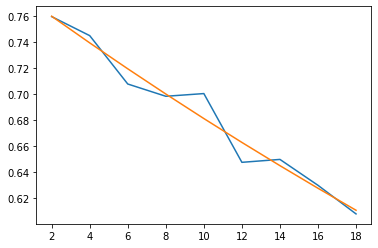

In [60]:
plt.plot(depths,results)
plt.plot(depths, [expfit(d, *popt) for d in depths])